> Code to accompany **Chapter 10: Defending Against Adversarial Inputs**

# Fashion-MNIST - Generating Adversarial Examples on a Drop-out Network

This notebook demonstrates how to generate adversarial examples using a network that incorporates randomised drop-out.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images/255.0
test_images = test_images/255.0
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Create a Simple Network with drop-out for Image Classification

We need to use the Keras __functional API__ (rather than the sequential API) to access the 
dropout capability with `training = True` at test time. 

The cell below has drop-out enabled at training time only. You can experiment by moving the drop-out layer 
or adding drop-out to test time by replacing the `Dropout` line as indicated in the comments.

In [2]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape=(28,28))
x = Flatten()(inputs)
x = Dense(56, activation='relu')(x)
x = Dropout(0.2)(x)                             # Use this line for drop-out at training time only
# x = Dropout(0.2)(x, training=True)            # Use this line instead for drop-out at test and training time
x = Dense(56, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

print(model)

model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 56)                43960     
_________________________________________________________________
dropout (Dropout)            (None, 56)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 56)                3192      
_________________________________________________________________
dense_2 (Dense)      

Train the model and evaluate it.

If drop-out is included at test time, the model will be unpredictable.

In [3]:
model.fit(train_images, train_labels, epochs=6)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Model accuracy based on test data:', test_acc)

Epoch 1/6
60000/60000 [==============================] - 4s 64us/sample - loss: 0.5789 - acc: 0.7922
Epoch 2/6
60000/60000 [==============================] - 4s 60us/sample - loss: 0.4324 - acc: 0.8424
Epoch 3/6
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3964 - acc: 0.8555
Epoch 4/6
60000/60000 [==============================] - 4s 61us/sample - loss: 0.3782 - acc: 0.8608
Epoch 5/6
60000/60000 [==============================] - 4s 75us/sample - loss: 0.3609 - acc: 0.8662
Epoch 6/6
10000/10000 [==============================] - 0s 41us/sample - loss: 0.3635 - acc: 0.8677
Model accuracy based on test data: 0.8677


## Create Some Adversarial Examples Using the Model

In [4]:
# Import helper function
import sys
sys.path.append('..')
from strengtheningdnns.adversarial_utils import generate_adversarial_data

In [5]:
import foolbox
fmodel = foolbox.models.TensorFlowModel.from_keras(model, bounds=(0, 255))

num_images = 1000
x_images = train_images[0:num_images, :]

attack_criterion = foolbox.criteria.Misclassification()
attack_fn = foolbox.attacks.GradientSignAttack(fmodel, criterion=attack_criterion)
x_adv_images, x_adv_perturbs, x_labels = generate_adversarial_data(original_images = x_images, 
                                                                   predictions = model.predict(x_images), 
                                                                   attack_fn = attack_fn)

C:\Users\katyw\Anaconda3\envs\strengthening-dnns\lib\site-packages\foolbox\attacks\base.py:148: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


## Take a Peek at some Results

The adversarial examples plotted should all be misclassified. However, if the model is running with drop-out at test 
time also (see model creation above), they may be classified correctly due to uncertainty of the model's behaviour.

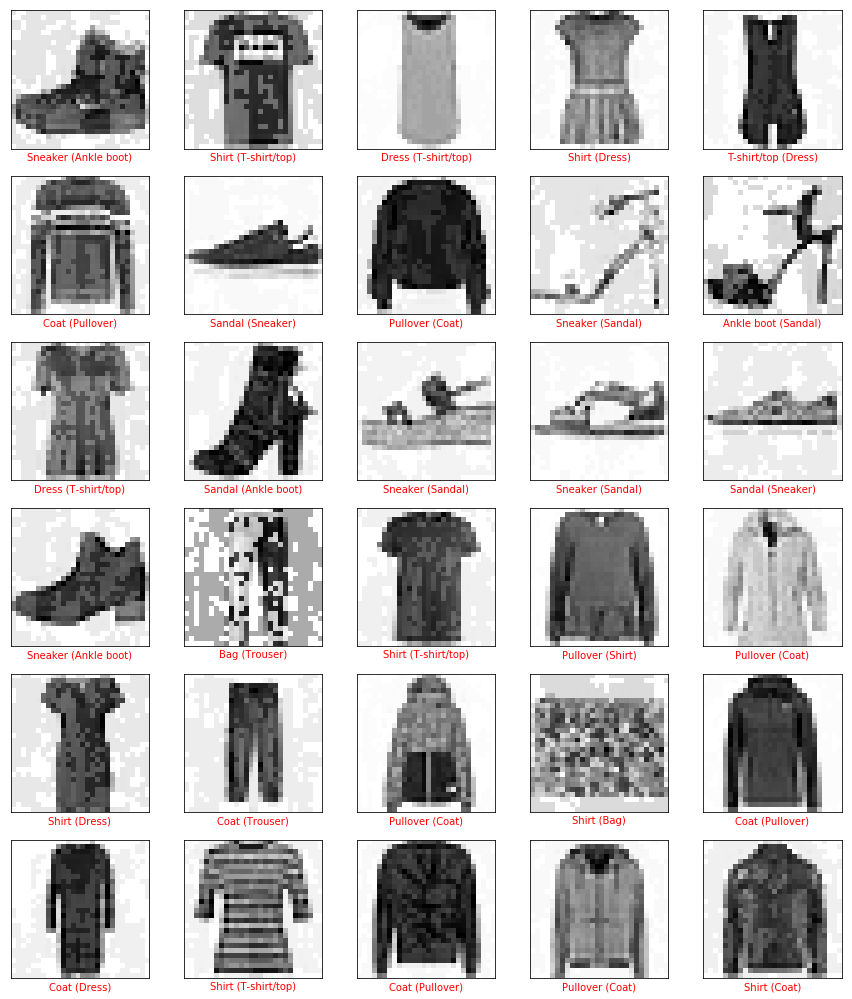

In [6]:
images_to_plot = x_adv_images

import matplotlib.pyplot as plt
adversarial_predictions = model.predict(images_to_plot)

plt.figure(figsize=(15, 30))
for i in range(30):
    plt.subplot(10,5,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images_to_plot[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(adversarial_predictions[i])
    original_label = x_labels[i]
    if predicted_label == original_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} ({})".format(class_names[predicted_label], 
                                class_names[original_label]), 
                                color=color)
    


Save the images if you wish so you can load them later.

In [8]:
np.save('../resources/test_images_GSAttack_dropout', x_adv_images)